In [1]:
!pip install benchmark_functions
!pip install scipy

In [ ]:
import random
from math import log2, ceil
from decimal import Decimal
import benchmark_functions as bf
import scipy

class Chromosom:
    def __init__(self, precision, variables_count, start_, end_):
        self.precision = precision
        self.variables_count = variables_count
        self.start_ = start_
        self.end_ = end_
        self.chromosom_len = ceil(self.precision * log2(self.end_ - self.start_))
        self.chromosoms = self._generate_chromosom()
        self.decoded_chromosom = self._decode_chromosom()

    def _generate_chromosom(self) -> list:
      chromosoms = []
      for i in range(self.variables_count):
        chromosom = []
        for i in range(self.chromosom_len):
            chromosom.append(random.randint(0, 1))
        chromosoms.append(chromosom)
      return chromosoms

    def _decode_chromosom(self) -> list:
      decoded_chromosom = []
      for chromosom in self.chromosoms:
        decimal_number = sum(bit * (2 ** i) for i, bit in enumerate(reversed(chromosom)))
        decoded = self.start_ + decimal_number * (self.end_ - self.start_) / (2 ** self.chromosom_len - 1)
        decoded_chromosom.append(Decimal(decoded).quantize(Decimal(10) ** -self.precision))
      return decoded_chromosom
    
    def __str__(self):
        return f"Chromosoms: {self.chromosoms} | Value in Decimal: {self.decoded_chromosom}"


class Individual:
    def __init__(self, precision, variables_count, start_, end_):
        self.chromosom = Chromosom(precision, variables_count, start_, end_)
        self.variables_count = variables_count

    def __str__(self):
        return f"{self.chromosom}"


class Population:
    def __init__(self, variables_count, population_size, precision, start_, end_, func, optimum):
        self.variables_count = variables_count
        self.population_size = population_size
        self.func = func 
        self.individuals = [Individual(precision, variables_count, start_, end_) for _ in range(self.population_size)]
        self.optimum = 0 if optimum == "min" else 1
        self.cell = self.getCell()
        self.precision = precision

    def getCell(self) -> dict:
        """Oblicza wartości funkcji celu dla populacji."""
        cell_dict = {}
        X = self.getX()
        for x in X:
            x_tuple = tuple(x)  
            cell_value = self.func(x) 
            cell_dict[x_tuple] = cell_value  
        return cell_dict
        
    def getSortedCell(self) -> list[tuple[tuple[float], float]]:
        """Sortuje wartości funkcji celu."""
        return sorted(self.cell.items(), key=lambda item: item[1], reverse=self.optimum)

    def getBestBySelection(self, percentage: float,) -> list:
        """Zwraca najlepsze osobniki według funkcji celu."""
        size = int(percentage * self.population_size / 100)
        # size = int(percentage * self.population_size)
        
        best_individuals = self.getSortedCell()
        return best_individuals[:size]
    
    def getBestByTournament(self, k) -> list:
      """Zwraca najlepsze osobniki według funkcji celu."""
      if k > self.population_size:
          raise ValueError("k parameter cannot be greater than population_size!")
      
      cell = self.cell.copy()
      best_individuals = []

      for _ in range(k):
          tournament = random.sample(list(cell.items()), int(self.population_size / k))  # Losujemy podzbiór
          if self.optimum == 1:
            best = max(tournament, key=lambda x: x[1])  # Wybieramy najlepszego osobnika (dla maksymalizacji)
          else:
            best = min(tournament, key=lambda x: x[1])  # Wybieramy najlepszego osobnika (dla minimalizacji)
          best_individuals.append(best)
          del cell[best[0]]  # Usuwamy wybranego osobnika

      return best_individuals

    def getBestByRulet(self) -> list:
        """Zwraca najlepsze osobniki według funkcji celu."""
        cell = self.cell.copy()
        best_individuals = []
        if self.optimum == 0:
          cell = {key: 1/value for key, value in cell.items()}
        total_fitness = sum(cell.values())
        if total_fitness == 0:
            raise ValueError("Total fitness is zero!")

        probabilities = {}
        distribution = {}
        distribution_value = 0

        for value in cell.values():
            probability = value / total_fitness
            probabilities[value] = probability
            distribution_value += probability
            distribution[value] = distribution_value

        if round(sum(probabilities.values())) != 1.0:
            raise ValueError("Sum of probabilities is not equal to 1!")
        last_item = round(list(distribution.items())[-1][1])
        if last_item != 1.0:
            raise ValueError("Last distribution value is not equal to 1!")
        num = random.random()
        for key, value in distribution.items():
            if num <= value:
                x = next(k for k, v in cell.items() if v == key)
                best_individuals.append((x, self.cell[x]))  # Zapisujemy klucz + wartość
                del cell[x]  # Usuwamy osobnika
                break
        return best_individuals
    
    #krzyżowanie jednopunktowe
    def single_point_crossover(self, parent1, parent2):
        """Krzyżowanie jednopunktowe dla chromosomów binarnych."""
        child1_chromosoms = []
        child2_chromosoms = []
    
        print("Parent 1 chromosoms:", parent1.chromosom.chromosoms)
        print("Parent 2 chromosoms:", parent2.chromosom.chromosoms)
    
        # Iterujemy po każdej zmiennej w chromosomie (bo może być ich kilka)
        for p1_chromo, p2_chromo in zip(parent1.chromosom.chromosoms, parent2.chromosom.chromosoms):
            end_of_range = len(p1_chromo)
            k = random.randint(1, end_of_range - 1)  # Punkt krzyżowania (nie może być 0)
            print(f"Crossover point: {k}")
    
            # Tworzymy nowe chromosomy dzieci
            new_p1 = p1_chromo[:k] + p2_chromo[k:]
            new_p2 = p2_chromo[:k] + p1_chromo[k:]
    
            child1_chromosoms.append(new_p1)
            child2_chromosoms.append(new_p2)
    
        # Tworzymy nowe osobniki
        child1 = Individual(parent1.chromosom.precision, parent1.variables_count, parent1.chromosom.start_, parent1.chromosom.end_)
        child2 = Individual(parent2.chromosom.precision, parent2.variables_count, parent2.chromosom.start_, parent2.chromosom.end_)
    
        # Podmieniamy chromosomy na nowe
        child1.chromosom.chromosoms = child1_chromosoms
        child2.chromosom.chromosoms = child2_chromosoms
    
        print("Child 1 chromosoms:", child1.chromosom.chromosoms)
        print("Child 2 chromosoms:", child2.chromosom.chromosoms)
    
        return child1, child2
    
    #krzyżowanie dwupunktowe
    def two_point_crossover(self, parent1, parent2, min_gap=1):
        """Krzyżowanie dwupunktowe dla chromosomów binarnych."""
        child1_chromosoms = []
        child2_chromosoms = []
    
        print("Parent 1 chromosoms:", parent1.chromosom.chromosoms)
        print("Parent 2 chromosoms:", parent2.chromosom.chromosoms)
    
        # Iterujemy po każdej zmiennej w chromosomie (bo może być ich kilka)
        for p1_chromo, p2_chromo in zip(parent1.chromosom.chromosoms, parent2.chromosom.chromosoms):
            end_of_range = len(p1_chromo)
            point1 = random.randint(1, end_of_range - 1)  # Pierwszy punkt krzyżowania (nie może być 0)
            while True:
                point2 = random.randint(1, end_of_range - 1)
                if point2 != point1 and abs(point2 - point1) >= min_gap:
                    break
            print(f"Crossover points: {point1} {point2}")
            
            lower = min(point1, point2)
            upper = max(point1, point2)
            print(lower, upper)
            # Tworzymy nowe chromosomy dzieci
            new_p1 = p1_chromo[:lower] + p2_chromo[lower:upper] + p1_chromo[upper:]
            new_p2 = p2_chromo[:lower] + p1_chromo[lower:upper] + p2_chromo[upper:]
            
            child1_chromosoms.append(new_p1)
            child2_chromosoms.append(new_p2)
            
        # Tworzymy nowe osobniki
        child1 = Individual(parent1.chromosom.precision, parent1.variables_count, parent1.chromosom.start_, parent1.chromosom.end_)
        child2 = Individual(parent2.chromosom.precision, parent2.variables_count, parent2.chromosom.start_, parent2.chromosom.end_)
    
        # Podmieniamy chromosomy na nowe
        child1.chromosom.chromosoms = child1_chromosoms
        child2.chromosom.chromosoms = child2_chromosoms
    
        print("Child 1 chromosoms:", child1.chromosom.chromosoms)
        print("Child 2 chromosoms:", child2.chromosom.chromosoms)
        
        return child1, child2
    
    def population_after_single_point_crossover(self, crossover_method_number, crossover_rate=1.0):
        """Wykonuje jednopunktowe krzyżowanie dla całej populacji."""
        new_population = []
        individuals = self.individuals[:]
        random.shuffle(individuals)
        
        for i in range(0, len(individuals) - 1, 2):
            parent1, parent2 = individuals[i], individuals[i + 1]
            
            if random.random() < crossover_rate:
                if crossover_method_number == 1:
                    child1, child2 = self.single_point_crossover(parent1, parent2)
                elif crossover_method_number == 2:
                    child1, child2 = self.two_point_crossover(parent1, parent2)
                new_population.extend([child1, child2])
            else:
                new_population.extend([parent1, parent2])
        
        self.individuals = new_population
        
    def getX(self) -> list:
        """Zwraca listę fenotypów (wartości zmiennych)."""
        return [[float(x) for x in individual.chromosom.decoded_chromosom] for individual in self.individuals]

    def __str__(self):
        return "\n".join(str(individual) for individual in self.individuals)
    
    def mutate_boundary(self, individual):
        """Mutacja brzegowa – zmienia pierwszy i/lub ostatni bit z określonym prawdopodobieństwem."""
        for c in individual.chromosom.chromosoms:
            if random.random() < 0.5:
                c[0] = 0 if c[0] == 1 else 1
            else:
                c[-1] = 0 if c[-1] == 1 else 1
        

        

    def mutate_one_point(self, individual):
        """Mutacja jednopunktowa – losowo zmienia jeden bit."""
        for c in individual.chromosom.chromosoms:
            index = random.randint(0, len(c) - 1)
            
            c[index] = 0 if c[index] == 1 else 1

    def mutate_two_point(self, individual):
        """Mutacja dwupunktowa – losowo zmienia dwa bity."""
        for c in individual.chromosom.chromosoms:
            indexes = random.sample(range(len(c)), 2)
            for idx in indexes:
                c[idx] = 0 if c[idx] == 1 else 1
            


    def population_after_mutationr(self, mutation_method, mutation_rate=1.0):
        new_population = []
        individuals = self.individuals[:]
        # random.shuffle(individuals)
        
        for i in range(0, len(individuals)):

            if random.random() < mutation_rate:
                if mutation_method == "One Point":
                    self.mutate_one_point(individuals[i])
                elif mutation_method == "Two Point":
                    self.mutate_two_point(individuals[i])
                elif mutation_method == "Boundary":
                   self.mutate_boundary(individuals[i])

        # print(self.individuals[0].chromosom.chromosoms)
        self.individuals
        
    def inversion(self, inversion_rate):
        """Operator inwersji – losowo odwraca fragment chromosomu z określonym prawdopodobieństwem."""

        for individual in self.individuals[:]:

            for c in individual.chromosom.chromosoms:
                if random.random() < inversion_rate:
                    idx1, idx2 = sorted(random.sample(range(len(c)), 2))

                    
                    c[idx1:idx2 + 1] = list(c[idx1:idx2 + 1])[::-1]
        
        print(self.individuals[0].chromosom.chromosoms)
                    
    def fitness(self, individual: Individual) :
        """Funkcja przystosowania, używa rzeczywistej funkcji celu.""" 
        # w sumie nie wiem którą wersję wziąść
        return self.func(individual.chromosom.decoded_chromosom)
        # return sum(x.count(1) for x in individual.chromosom.chromosoms) 


    def elitism(self, elite_percent: float = 0.1, elite_count: int = None):

        """Strategia elitarna – wybiera najlepsze osobniki do nowej populacji."""
        sorted_population = sorted(self.individuals, key=lambda ind: self.fitness(ind), reverse=True)

        elite_num = elite_count if elite_count else int(self.population_size * elite_percent)
        elite_num = max(1, elite_num)

        return sorted_population[:elite_num]         

In [40]:
c = Chromosom(10, 5, -10, 10)
chromosoms = c.chromosoms
decoded_chromosom = c.decoded_chromosom
print(c)


Chromosoms: [[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1], [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0], [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]] | Value in Decimal: [Decimal('5.4119520876'), Decimal('-9.9700619155'), Decimal('-1.1176429094'), Decimal('-6.2863695218'), Decimal('-4.6158674409')]


In [3]:
func = bf.Schwefel(n_dimensions=3)

population = Population(3, 10, 10, -10, 10, func, "min")

population.getBestByRulet()


[((1.102796058, 6.2400302594, 7.6053796236), 1249.3997214449325)]

In [43]:
population.population_after_single_point_crossover(2, crossover_rate=0.5)


Parent 1 chromosoms: [[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], [1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1], [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]]
Parent 2 chromosoms: [[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]]
Crossover points: 8 3
3 8
Crossover points: 16 6
6 16
Crossover points: 19 24
19 24
Child 1 chromosoms: [[1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0

In [ ]:
population = Population(2, 5, 5, -2, 2, lambda x: sum(xi ** 2 for xi in x), "min")

for i in population.individuals:
    print(i.chromosom.chromosoms)

print("---------------------------------------------------------")
print(population.population_after_mutationr("Two Point",1))


for ind in population.individuals:
    print(f"Chromosom: {ind.chromosom.chromosoms}, Fitness: {population.fitness(ind)}")

elite =population.elitism()
print("\nWybrane elitarne osobniki:")
for ind in elite:
    print(f"Chromosom: {ind.chromosom.chromosoms}, Fitness: {population.fitness(ind)}")

[[1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0]]
[[0, 1, 1, 1, 1, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]
[[0, 1, 0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]]
[[1, 0, 0, 1, 0, 0, 0, 0, 1, 1], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1]]
[[0, 0, 0, 1, 0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 1, 0, 1]]
---------------------------------------------------------
[[1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 0]]
None
Chromosom: [[1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 0]], Fitness: 1.0972061165
Chromosom: [[0, 1, 1, 1, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 0, 1, 1, 0]], Fitness: 2.2644345268
Chromosom: [[1, 1, 0, 0, 0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 1, 1, 0, 1, 0]], Fitness: 0.8365082741
Chromosom: [[1, 0, 1, 1, 0, 1, 0, 0, 1, 1], [0, 1, 0, 0, 1, 0, 0, 0, 0, 1]], Fitness: 1.9478744753
Chromosom: [[0, 0, 0, 1, 0, 1, 1, 1, 0, 1], [0, 1, 1, 1, 1, 0, 1, 1, 0, 0]], Fitness: 2.8997256573

Wybrane elitarne osobniki:
Chromosom: [[0, 0, 0, 1,

Gui:

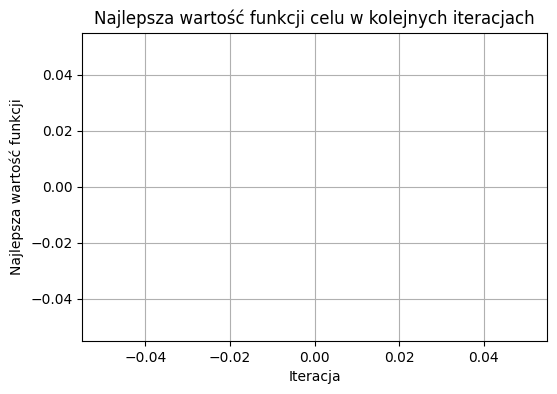

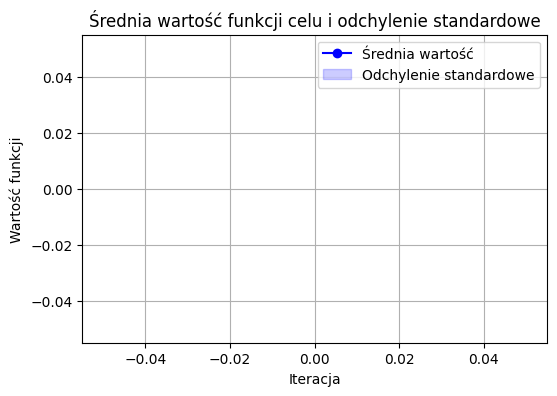

In [12]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from decimal import Decimal, getcontext
import math
getcontext().prec = 50 
import numpy as np

#  potem do dodania jak wybierzemy --------------------------------------------------------------------------------
def get_function(name):
    """Zwraca wybraną funkcję testową na podstawie jej nazwy."""
    if name == "Function 1":
        return lambda x: sum(xi ** 2 for xi in x)
    elif name ==  "Function 2":
        # return lambda x: 10 * len(x) + sum(xi ** 2 - 10 * np.cos(2 * np.pi * xi) for xi in x)
    # elif name == "Ackley":
        return lambda x: Decimal(-20) * (-Decimal("0.2") * (sum(Decimal(xi)**2 for xi in x) / len(x)).sqrt()).exp() - \
                 sum(Decimal(math.cos(2 * math.pi * float(xi))) for xi in x) / len(x) + Decimal(20) + Decimal(math.e)
    else:
        raise ValueError("Nieznana funkcja")


# od wyukresów aby sie dało przewijać - jescze do dopracowania------------------------------------------------------------------
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class PlotViewer:
    def __init__(self, root, best_fitness_values, avg_fitness_values, std_fitness_values):
        """Klasa do wyświetlania wykresów wyników algorytmu genetycznego."""
        self.plot_window = tk.Toplevel(root)
        self.plot_window.title("Wykresy Algorytmu Genetycznego")
        self.plot_window.geometry("850x600")

        self.figures = []
        self.current_index = 0

        # **🔹 Wykres 1: Najlepsza wartość funkcji celu od iteracji 🔹**
        fig1, ax1 = plt.subplots(figsize=(6, 4))
        ax1.plot(range(len(best_fitness_values)), best_fitness_values, marker='o', linestyle='-', color='red')
        ax1.set_xlabel("Iteracja")
        ax1.set_ylabel("Najlepsza wartość funkcji")
        ax1.set_title("Najlepsza wartość funkcji celu w kolejnych iteracjach")
        ax1.grid(True)
        self.figures.append(fig1)

        # **🔹 Wykres 2: Średnia wartość i odchylenie standardowe 🔹**
        fig2, ax2 = plt.subplots(figsize=(6, 4))
        ax2.plot(range(len(avg_fitness_values)), avg_fitness_values, label="Średnia wartość", marker='o', linestyle='-', color='blue')
        ax2.fill_between(range(len(avg_fitness_values)),
                         np.array(avg_fitness_values) - np.array(std_fitness_values),
                         np.array(avg_fitness_values) + np.array(std_fitness_values),
                         color='blue', alpha=0.2, label="Odchylenie standardowe")
        ax2.set_xlabel("Iteracja")
        ax2.set_ylabel("Wartość funkcji")
        ax2.set_title("Średnia wartość funkcji celu i odchylenie standardowe")
        ax2.legend()
        ax2.grid(True)
        self.figures.append(fig2)

        # **🔹 Wyświetlanie wykresu 🔹**
        self.canvas = FigureCanvasTkAgg(self.figures[self.current_index], master=self.plot_window)
        self.plot_widget = self.canvas.get_tk_widget()
        self.plot_widget.pack(pady=20)

        # **🔹 Kontrolki nawigacji 🔹**
        self.button_frame = tk.Frame(self.plot_window)
        self.button_frame.pack(pady=10)

        self.prev_button = ttk.Button(self.button_frame, text="◀ Poprzedni", command=self.show_previous)
        self.prev_button.grid(row=0, column=0, padx=10)

        self.next_button = ttk.Button(self.button_frame, text="Następny ▶", command=self.show_next)
        self.next_button.grid(row=0, column=1, padx=10)

        self.update_buttons()

    def show_previous(self):
        """Przełącza na poprzedni wykres."""
        if self.current_index > 0:
            self.current_index -= 1
            self.update_plot()

    def show_next(self):
        """Przełącza na następny wykres."""
        if self.current_index < len(self.figures) - 1:
            self.current_index += 1
            self.update_plot()

    def update_plot(self):
        """Aktualizuje wyświetlany wykres."""
        self.plot_widget.destroy()
        self.canvas = FigureCanvasTkAgg(self.figures[self.current_index], master=self.plot_window)
        self.plot_widget = self.canvas.get_tk_widget()
        self.plot_widget.pack(pady=20)
        self.update_buttons()

    def update_buttons(self):
        """Aktualizuje stan przycisków nawigacyjnych."""
        self.prev_button.config(state="normal" if self.current_index > 0 else "disabled")
        self.next_button.config(state="normal" if self.current_index < len(self.figures) - 1 else "disabled")

#  tutaj obsłużyc te wszystki ecklasy i funkcje jak wiesz co twoja klasa robi to mozesz dopisać -------------------------------- ---------------  
def start_algorithm():
    """Funkcja uruchamiająca algorytm genetyczny i zapisująca wyniki dla wykresów."""
    
    def get_value(var, default, cast_type=float):
        try:
            value = var.get()
            return cast_type(value) if value else default
        except ValueError:
            return default

    # Pobieranie wartości z GUI
    start_ = get_value(begin_var, -10.0)
    end_ = get_value(end_var, 10.0)
    precision = get_value(precision_var, 4, int)
    population_size = get_value(population_var, 50, int)
    epochs = get_value(epochs_var, 100, int)
    variables_count = get_value(params_var, 2, int)
    elite_percent = get_value(elite_var, 10.0) / 100
    cross_prob = get_value(cross_prob_var, 0.8)
    mutation_prob = get_value(mutation_prob_var, 0.05)
    inversion_prob = get_value(inversion_prob_var, 0.01)
    selection_method = selection_var.get() or "Roulette Wheel"
    best_select_percent = get_value(best_select_var, 20.0) / 100
    tournament_size = get_value(tournament_var, 3, int) if selection_method == "Tournament" else None
    cross_method = cross_method_var.get() or "Single Point"
    mutation_method = mutation_method_var.get() or "One Point"
    function_name = function_var.get() or "Rastrigin"
    is_maximization = maximization_var.get() if maximization_var.get() else True  

    # Pobranie funkcji celu
    func = get_function(function_name)

    # Inicjalizacja populacji
    population = Population(variables_count, population_size, precision, start_, end_, func, "max" if is_maximization else "min")


    # Listy do przechowywania danych dla wykresów
    best_fitness_values = []
    avg_fitness_values = []
    std_fitness_values = []

    # do zrobienia wywołanie tego czegoś ------------------------------------------------------------------------------------------------------------
       

    # Przekazanie danych do wykresów
    PlotViewer(root, best_fitness_values, avg_fitness_values, std_fitness_values)



# to tam mało istotne co jest niżej ----------------------------------------------------------------------------------------------

def update_tournament_visibility(*args):
    """Pokazuje pole 'Tournament size' tylko jeśli wybrano 'Tournament'."""
    if selection_var.get() == "Tournament":
        tournament_label.grid(row=2, column=0, padx=5, pady=2)
        tournament_entry.grid(row=2, column=1, padx=5, pady=2)
    else:
        tournament_label.grid_remove()
        tournament_entry.grid_remove()
        
# Tworzenie głównego okna
root = tk.Tk()
root.title("Genetic Algorithm Configuration")
root.geometry("350x550")

# Tworzenie pól wejściowych
begin_var = tk.StringVar()
end_var = tk.StringVar()
precision_var = tk.StringVar()
population_var = tk.StringVar()
epochs_var = tk.StringVar()
params_var = tk.StringVar()
elite_var = tk.StringVar()
cross_prob_var = tk.StringVar()
mutation_prob_var = tk.StringVar()
inversion_prob_var = tk.StringVar()
best_select_var = tk.StringVar()
tournament_var = tk.StringVar()

# Tworzenie list rozwijanych
selection_var = tk.StringVar(value="Roulette Wheel")
selection_var.trace_add("write", update_tournament_visibility)  # Automatyczna reakcja na zmianę

cross_method_var = tk.StringVar(value="One-Point")
mutation_method_var = tk.StringVar(value="Boundary")
function_var = tk.StringVar(value="Function 1")

# Minimalizacja/maksymalizacja (radio buttons)
maximization_var = tk.BooleanVar(value=True)

# Tworzymy ramkę dla lepszego układu
frame = tk.Frame(root)
frame.pack(pady=10)

fields = [
    ("Begin of the range", begin_var),
    ("End of the range", end_var),
    ("Precision", precision_var),
    ("Population", population_var),
    ("Epochs", epochs_var),
    ("Number of parameters", params_var),
    ("Percentage elite strategy", elite_var),
    ("Cross probability", cross_prob_var),
    ("Mutation probability", mutation_prob_var),
    ("Inversion probability", inversion_prob_var),
]

# Tworzenie pól w układzie tabeli (grid)
for i, (label, var) in enumerate(fields):
    tk.Label(frame, text=label, anchor="w", width=23).grid(row=i, column=0, padx=0, pady=2)
    tk.Entry(frame, textvariable=var, width=15).grid(row=i, column=1, padx=5, pady=2)

# Listy rozwijane
select_frame1 = tk.Frame(root)
select_frame1.pack(pady=0)

tk.Label(select_frame1, text="Selection method", anchor="w", width=25).grid(row=0, column=0)
selection_combobox = ttk.Combobox(select_frame1, textvariable=selection_var, values=["Roulette Wheel", "Best solution", "Tournament"], width=15)
selection_combobox.grid(row=0, column=1)
selection_combobox.state(["readonly"])

tk.Label(select_frame1, text="Percentage the best to select", anchor="w", width=23).grid(row=1, column=0, padx=0, pady=2)
tk.Entry(select_frame1, textvariable=best_select_var, width=15).grid(row=1, column=1, padx=5, pady=2)

tournament_label = tk.Label(select_frame1, text="Tournament size", anchor="w", width=25)
tournament_entry = tk.Entry(select_frame1, textvariable=tournament_var, width=15)

update_tournament_visibility()

select_frame = tk.Frame(root)
select_frame.pack(pady=0)

tk.Label(select_frame, text="Cross method", anchor="w", width=25).grid(row=0, column=0)
cross_method_combobox = ttk.Combobox(select_frame, textvariable=cross_method_var, values=["One-Point", "Two-Point", "Tree-Point", "Uniform crossover", "Granular crossover"], width=15)
cross_method_combobox.grid(row=1, column=1)
cross_method_combobox.state(["readonly"])

tk.Label(select_frame, text="Mutation method", anchor="w", width=25).grid(row=1, column=0)
mutation_method_combobox = ttk.Combobox(select_frame, textvariable=mutation_method_var, values=["Boundary", "One-Point", "Two-Point"], width=15)
mutation_method_combobox.grid(row=2, column=1)
mutation_method_combobox.state(["readonly"]) 

tk.Label(select_frame, text="Function to calculation", anchor="w", width=25).grid(row=2, column=0)
function_combobox = ttk.Combobox(select_frame, textvariable=function_var, values=["Function 1", "Function 2"], width=15)
function_combobox.grid(row=3, column=1)
function_combobox.state(["readonly"])

# Radio buttony dla minimalizacji/maksymalizacji
radio_frame = tk.Frame(root)
radio_frame.pack(pady=2)

tk.Label(radio_frame, text="Optimization type:", anchor="w", width=25).grid(row=0, column=0)
tk.Radiobutton(radio_frame, text="Minimization", variable=maximization_var, value=False).grid(row=1, column=0)
tk.Radiobutton(radio_frame, text="Maximization", variable=maximization_var, value=True).grid(row=1, column=1)

# Przycisk startowy
tk.Button(root, text="Start", command=start_algorithm, width=7, height=1).pack(pady=10)

# Uruchomienie aplikacji
root.mainloop()
